### Deep Learning  Assignment
**by- ed24s401**

##### ANSWER 1

Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

In [16]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ed24s401 (ed24s401-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


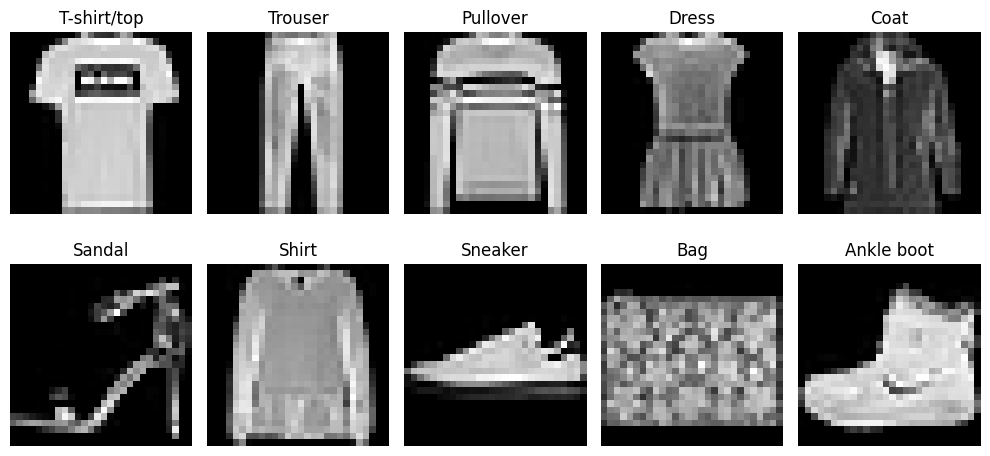

In [ ]:

wandb.init(project='fashion-MNIST dataset', name='fashion-MNIST samples')
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_lbs=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
fig, axes=plt.subplots(2,5, figsize=(10,5))
axes=axes.flatten()
marked_img=[]

for i in range(10):
    idx=np.where(y_train ==i)[0][0]
    axes[i].imshow(x_train[idx], cmap='gray')
    axes[i].set_title(class_lbs[i])
    axes[i].axis('off')
    marked_img.append(wandb.Image(x_train[idx], caption=class_lbs[i]))

plt.tight_layout() 
plt.show()
#logging figure to wandb
wandb.log({"fashion-MNIST samples": marked_img})
wandb.finish()



In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
#loading the dataset
(x_train_full, y_train_full), (x_test,y_test)=fashion_mnist.load_data()
 
# normalize images
x_train_full=x_train_full.reshape(x_train_full.shape[0], -1)/255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0
#shuffle dataset
np.random.seed(42)
indices=np.arange(x_train_full.shape[0])
np.random.shuffle(indices)

x_train_full, y_train_full=x_train_full[indices], y_train_full[indices]

# splitting the dataset into training(85%) and validation(15%)
train_size=int(.85*len(x_train_full))

x_train, y_train=x_train_full[:train_size],y_train_full[:train_size]
x_val, y_val=x_train_full[train_size:], y_train_full[train_size:]

#converting truth(y) into one hot vector
t_classes=10
y_train_1h=np.eye(t_classes)[y_train]
y_val_1h=np.eye(t_classes)[y_val]
y_test_1h=np.eye(t_classes)[y_test]
print(len(x_test))

# print(f"Train set: {x_train.shape}, Validation set: {x_val.shape}, Test set: {x_test.shape}") #Train set: (51000, 784), Validation set: (9000, 784), Test set: (10000, 784)
# print(f"\n{y_train_1h.shape},  {y_val_1h.shape}") #(51000, 10), (9000, 10)



10000


### Answer 2.

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer

In [4]:

class feed_forward_NN:

    def __init__(self, layers):
        self.layers=layers
        self.weights=[]
        self.biases=[]
        self.layer_n=len(layers)

        for i in range(self.layer_n-1):
            w=np.random.randn(self.layers[i],self.layers[i+1])*np.sqrt(2/self.layers[i]) #size(self.layers[i] x self.layers[i+1])
            b=np.zeros((1,self.layers[i+1])) #size(self.layers[i] x self.layers[i+1])
            self.weights.append(w)
            self.biases.append(b)

    def sigmoid(self,x):
        return 1/ (1+np.exp(-np.clip(x, -500, 500)))
    
    def softmax(self, x):
        exp_x=np.exp(x-np.max(x, axis=1, keepdims=True))
        return exp_x/np.sum(exp_x, axis=1, keepdims=True)
        
    def sig_derivative(self, x):
        return x*(1-x)
    
    def forward_pass(self,x):
        self.h=[x]
        for i in range(self.layer_n-2):
            a=np.dot(self.h[i], self.weights[i])+ self.biases[i]
            h=self.sigmoid(a)
            self.h.append(h)
        #Output_layer  _using_softmax
        a_out=np.dot(self.h[-1],self.weights[-1]) +self.biases[-1]
        h_out=self.softmax(a_out)
        self.h.append(h_out)
        return self.h
    
    def predicted_prob_distribution(self,x):
        y_cap=self.forward_pass(x)
        return y_cap[-1]

In [17]:
hidden_layers=[128,64]
layers=[784]+hidden_layers+[10]
print(layers)

network=feed_forward_NN(layers)
predictions=network.predicted_prob_distribution(x_train_full)
print(predictions)


[784, 128, 64, 10]
[[0.17872513 0.06798745 0.14031561 ... 0.06762071 0.08305973 0.14672065]
 [0.18367809 0.0761571  0.13851677 ... 0.06825291 0.08191982 0.1487257 ]
 [0.18505874 0.07433587 0.13848236 ... 0.06651154 0.0749203  0.15048631]
 ...
 [0.16821616 0.07813909 0.14520503 ... 0.07010719 0.07921877 0.15076432]
 [0.16913051 0.08037744 0.1403648  ... 0.06633245 0.08263289 0.15581743]
 [0.17724641 0.06945173 0.13648755 ... 0.07517653 0.08473997 0.14867274]]


### ANSWER 3

Implement the backpropagation algorithm with support for the following optimisation functions

- **sgd**
- **momentum based gradient descent**
- **nesterov accelerated gradient descent**
- **rmsprop**
- **adam**
- **nadam**

In [54]:

class feed_forward_NN_3:

    def __init__(self, layers, optimizer, learning_rate, momentum, beta1, beta2, beta_rms, epsilon):
        
        
        self.layers=layers
        self.layer_n=len(layers)
        self.optimizer= optimizer.lower()
        self.lr=learning_rate
        self.momentum=momentum
        self.beta1=beta1
        self.beta2=beta2
        self.beta_rms=beta_rms
        self.epsilon=epsilon

        self.weights=[]
        self.biases=[]
        
        

        for i in range(self.layer_n-1):
            # initialization for hidden layers
            w=np.random.randn(layers[i],layers[i+1])*np.sqrt(2.0/layers[i]) #size(self.layers[i] x self.layers[i+1])
            b=np.zeros((1,layers[i+1])) #size(self.layers[i] x self.layers[i+1])
            self.weights.append(w)
            self.biases.append(b)

        # initialization of extra parameters for diff optimizers
        self._init_optim_params()

    def _init_optim_params(self):

        # common for  momentum, NAG, Adam, etc.
        if self.optimizer in ["momentum", "nesterov", "adam", "nadam", "rmsprop"]:
            self.v_w=[np.zeros_like(w) for w in self.weights]
            self.v_b=[np.zeros_like(b) for b in self.biases]

        # RMSProp or Adam or NADam (second moment)
        # if self.optimizer in ["rmsprop","adam", "nadam"]:
        #     self.s_w = [np.zeros_like(w) for w in self.weights]
        #     self.s_b =[np.zeros_like(b) for b in self.biases]

        # Adam or Nadam ( first moment and time step)
        if self.optimizer in ["adam","nadam"]:
            self.m_w =[np.zeros_like(w) for w in self.weights]
            self.m_b =[np.zeros_like(b) for b in self.biases]
            self.t =0


    def sigmoid(self,x):
        return 1/ (1+np.exp(-np.clip(x, -500, 500)))
    
    def softmax(self, x):
        exp_x=np.exp(x-np.max(x, axis=1, keepdims=True))
        return exp_x/np.sum(exp_x, axis=1, keepdims=True)
        
    def sig_derivative(self, x):
        return x*(1-x)
    
    def forward_pass(self,x):
        self.h=[x]
        for i in range(self.layer_n-2):
            a=np.dot(self.h[i], self.weights[i])+ self.biases[i]
            h=self.sigmoid(a)
            self.h.append(h)
        #Output_layer  _using_softmax
        a_out=np.dot(self.h[-1],self.weights[-1]) +self.biases[-1]
        h_out=self.softmax(a_out)
        self.h.append(h_out)
        return self.h
    
    def backward_prop(self,y_true):
        #batch_len=len(x)
        m = y_true.shape[0]
        dw = [None] * (self.layer_n - 1)
        db = [None] * (self.layer_n - 1)

        #gradient with respect to outpur layer
        delta=self.h[-1]-y_true
        #gradient wit respect to hidden layers
        for i in reversed(range(self.layer_n-1)):
            dw[i]=np.dot(self.h[i].T, delta)/m
            db[i]=np.sum(delta,axis=0,keepdims=True)/m

            if i>0:
                delta=np.dot(delta,self.weights[i].T)*self.sig_derivative(self.h[i])

        return dw, db
    
    def _update_params(self, dw, db):

        if self.optimizer =="sgd":
            #Stochastic Gradient Descent
            for i in range(self.layer_n -1):
                self.weights[i]-= self.lr *dw[i]
                self.biases[i]-= self.lr* db[i]

        elif self.optimizer =="momentum":
            for i in range(self.layer_n -1):
                self.v_w[i]= self.momentum*self.v_w[i] +dw[i]
                self.v_b[i]= self.momentum*self.v_b[i]+db[i]

                self.weights[i]-= self.lr*self.v_w[i]
                self.biases[i] -= self.lr*self.v_b[i]               

        elif self.optimizer =="rmsprop":
            for i in range(self.layer_n-1):
                self.v_w[i] = self.beta_rms * self.v_w[i] + (1 - self.beta_rms) * (dw[i] ** 2)
                self.v_b[i] = self.beta_rms * self.v_b[i] + (1 - self.beta_rms) * (db[i] ** 2)
                self.weights[i] -= self.lr * dw[i] / (np.sqrt(self.v_w[i] )+ self.epsilon)
                self.biases[i]  -= self.lr * db[i] / (np.sqrt(self.v_b[i] )+ self.epsilon)

        elif self.optimizer == "adam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

                self.weights[i] -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        elif self.optimizer == "nadam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** (self.t+1))
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** (self.t+1))
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** (self.t+1))
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** (self.t+1))

                # final update
                grad_term_w = self.beta1 * m_w_hat + (1 - self.beta1) * dw[i] / (1 - self.beta1 ** (self.t+1))
                grad_term_b = self.beta1 * m_b_hat + (1 - self.beta1) * db[i] / (1 - self.beta1 ** (self.t+1))

                self.weights[i] -= self.lr * grad_term_w / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * grad_term_b / (np.sqrt(v_b_hat) + self.epsilon)
    
    def _train_step(self, x_batch, y_batch):
         
        if self.optimizer == "nesterov":
            # shit to look-ahead: w_look = w - momentum * v
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.momentum * self.v_w[i]
                self.biases[i]  -= self.momentum * self.v_b[i]

            # forward + backward at the look-ahead position
            self.forward_pass(x_batch)
            out = self.h[-1]
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1)) 
            dW, dB = self.backward_prop(y_batch)

            # shift back to original w_t
            for i in range(self.layer_n - 1):
                self.weights[i] += self.momentum * self.v_w[i]
                self.biases[i]  += self.momentum * self.v_b[i]

            # update velocity: u_t = beta*u_{t-1} + grad_look
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dW[i]
                self.v_b[i] = self.momentum * self.v_b[i] + dB[i]

            # final update: w_{t+1} = w_t - lr * u_t
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i]  -= self.lr * self.v_b[i]

            return loss

        else:
            # Normal forward/back
            self.forward_pass(x_batch)
            out = self.h[-1]
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))

            # Backward pass
            dw, db = self.backward_prop(y_batch)

            # Update parameters with the chosen optimizer
            self._update_params(dw, db)

            return loss

    def training(self, x_train, y_train, x_val, y_val, epochs, batch_size,wandb_project):
        wandb.init(project=wandb_project, config={
            "optimizer": self.optimizer,
            "learning_rate": self.lr,
            "momentum": self.momentum,
            "beta1": self.beta1,
            "beta2": self.beta2,
            "beta_rms": self.beta_rms,
            "epsilon": self.epsilon,
            "epochs": epochs,
            "batch_size": batch_size,
            "layers": self.layers
        })


        #n_samples=len(x_train)
        for ep in range(epochs):

            # Shuffel data
            idx=np.random.permutation(x_train.shape[0],)
            x_train_shuff=x_train[idx]
            y_train_shuff=y_train[idx]

            n_batches=len(x_train)// batch_size
            batch_no=0   
            epoch_loss=0

            for b in range(n_batches):
                start = b* batch_size
                end =start+batch_size
                x_batch=x_train_shuff[start: end]
                y_batch=y_train_shuff[start: end]

                # forward pass
                loss=self._train_step(x_batch, y_batch)
                batch_no+=1
                epoch_loss+=loss

            # average loss        
            loss_avg=epoch_loss/batch_no

            # use of validation dataset for predictions
            valid_prediction= self.predict(x_val)
            val_labels=np.argmax(y_val, axis =1)
            valid_accuracy=np.mean(valid_prediction ==val_labels)

            # loging in wandb
            wandb.log({'epoch':ep+1, 'training_loss' : loss_avg, 'validation_accuracy': valid_accuracy})
            print(f"epoch: {ep+1}/{epochs}, train_loss:{loss_avg:.5f}, val_accuracy: {valid_accuracy:.5f}")

        wandb.finish()
    

    def predict_prob(self, x):
        self.forward_pass(x)
        return self.h[-1]

    def predict(self,x):
        y_cap=self.forward_pass(x)
        return np.argmax(y_cap[-1], axis=1)
    

if __name__=="__main__":
    optimizer_name="sgd"

    model =feed_forward_NN_3(
        layers=[784, 128, 64, 10],
        optimizer=optimizer_name,
        learning_rate=0.1,
        momentum=0.9,
        beta1=0.9,
        beta2=0.999,
        beta_rms=0.9,
        epsilon=1e-8,
    )
    model.training(
        x_train=x_train,
        y_train=y_train_1h,
        x_val=x_val,
        y_val=y_val_1h,
        epochs=10,
        batch_size=64,
        wandb_project="backpropagation framework"
    )

    test_preds = model.predict(x_test)
    test_labels = np.argmax(y_test_1h, axis=1)
    test_acc = np.mean(test_preds == test_labels)
    print("Test Accuracy:", test_acc)





epoch: 1/10, train_loss:1.19047, val_accuracy: 0.74600
epoch: 2/10, train_loss:0.64018, val_accuracy: 0.79189
epoch: 3/10, train_loss:0.54309, val_accuracy: 0.81644
epoch: 4/10, train_loss:0.49514, val_accuracy: 0.82978
epoch: 5/10, train_loss:0.46597, val_accuracy: 0.83911
epoch: 6/10, train_loss:0.44591, val_accuracy: 0.84022
epoch: 7/10, train_loss:0.43001, val_accuracy: 0.84822
epoch: 8/10, train_loss:0.41902, val_accuracy: 0.84700
epoch: 9/10, train_loss:0.40808, val_accuracy: 0.85422
epoch: 10/10, train_loss:0.39895, val_accuracy: 0.85789


epoch,▁▂▃▃▄▅▆▆▇█
training_loss,█▃▂▂▂▁▁▁▁▁
validation_accuracy,▁▄▅▆▇▇▇▇██
epoch,10
training_loss,0.39895
validation_accuracy,0.85789


Test Accuracy: 0.8453


#### ANSWER 4.

In [60]:
# import numpy as np
# import wandb
# from keras.datasets import fashion_mnist

# #############################################
# # Sweep Functionality for Q4
# #############################################
# def train_sweep():
#     wandb.init()
#     config = wandb.config

#     # Load and preprocess Fashion-MNIST
#     (x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
#     x_train_full = x_train_full.reshape(x_train_full.shape[0], -1) / 255.0
#     x_test = x_test.reshape(x_test.shape[0], -1) / 255.0
#     np.random.seed(42)
#     idx = np.arange(x_train_full.shape[0])
#     np.random.shuffle(idx)
#     x_train_full = x_train_full[idx]
#     y_train_full = y_train_full[idx]
#     train_size = int(0.85 * x_train_full.shape[0])
#     x_train = x_train_full[train_size:]
#     y_train = y_train_full[train_size:]
#     x_val = x_train_full[:train_size]
#     y_val = y_train_full[:train_size]

#     num_classes = 10
#     y_train_1h = np.eye(num_classes)[y_train]
#     y_val_1h = np.eye(num_classes)[y_val]
#     y_test_1h = np.eye(num_classes)[y_test]

#     # Build model with hyperparameters from wandb.config
#     model = feed_forward_NN_4(
#         layers=[784] + [config.hidden_size] * config.num_hidden_layers + [10],
#         optimizer=config.optimizer,
#         learning_rate=config.learning_rate,
#         momentum=config.momentum,
#         beta1=config.beta1,
#         beta2=config.beta2,
#         beta_rms=config.beta_rms,
#         epsilon=config.epsilon,
#         weight_decay=config.weight_decay,
#         init_type=config.init_type,
#         activation=config.activation
#     )

#     model.training(
#         x_train=x_train,
#         y_train=y_train_1h,
#         x_val=x_val,
#         y_val=y_val_1h,
#         epochs=config.epochs,
#         batch_size=config.batch_size,
#         wandb_project="q4_sweep_project"
#     )

#     test_preds = model.predict(x_test)
#     test_labels = np.argmax(y_test_1h, axis=1)
#     test_acc = np.mean(test_preds == test_labels)
#     wandb.log({"test_accuracy": test_acc})

# #############################################
# # Sweep Configuration for Q4
# #############################################
# sweep_config = {
#     "method": "random",
#     "metric": {
#         "name": "validation_accuracy",
#         "goal": "maximize"
#     },
#     "parameters": {
#         "epochs": {"values": [5, 10]},
#         "num_hidden_layers": {"values": [3, 4, 5]},
#         "hidden_size": {"values": [32, 64, 128]},
#         "weight_decay": {"values": [0.0, 0.0005, 0.5]},
#         "learning_rate": {"values": [1e-3, 1e-4]},
#         "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
#         "batch_size": {"values": [16, 32, 64]},
#         "init_type": {"values": ["random", "xavier"]},
#         "activation": {"values": ["sigmoid", "tanh", "relu"]},
#         "momentum": {"values": [0.8, 0.9]},
#         "beta1": {"values": [0.9]},
#         "beta2": {"values": [0.999]},
#         "beta_rms": {"values": [0.9]},
#         "epsilon": {"values": [1e-8]}
#     }
# }

# class feed_forward_NN_4:
#     def __init__(self, layers, optimizer, learning_rate, momentum, beta1, beta2, beta_rms, epsilon, weight_decay, init_type, activation):
        
        
#         self.layers = layers
#         self.layer_n = len(layers)
#         self.optimizer = optimizer.lower()
#         self.lr = learning_rate
#         self.momentum = momentum
#         self.beta1 = beta1
#         self.beta2 = beta2
#         self.beta_rms = beta_rms
#         self.epsilon = epsilon
#         self.weight_decay = weight_decay
#         self.init_type = init_type.lower()
#         self.activation = activation.lower()

#         self.weights = []
#         self.biases = []
        
#         # Weight initialization: "xavier" or "random"
#         for i in range(self.layer_n - 1):
#             if self.init_type == "xavier":
#                 w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(1.0 / layers[i])
#             else:
#                 w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2.0 / layers[i])
#             b = np.zeros((1, layers[i+1]))
#             self.weights.append(w)
#             self.biases.append(b)

#         # Initialize extra optimizer parameters
#         self._init_optim_params()

#     def _init_optim_params(self):
#         # For momentum, Nesterov, RMSProp, Adam, Nadam: initialize velocity
#         if self.optimizer in ["momentum", "nesterov", "rmsprop", "adam", "nadam"]:
#             self.v_w = [np.zeros_like(w) for w in self.weights]
#             self.v_b = [np.zeros_like(b) for b in self.biases]
#         # For Adam and Nadam: first moment and time step
#         if self.optimizer in ["adam", "nadam"]:
#             self.m_w = [np.zeros_like(w) for w in self.weights]
#             self.m_b = [np.zeros_like(b) for b in self.biases]
#             self.t = 0

#     # Activation functions
#     def sigmoid(self, x):
#         return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
#     def tanh(self, x):
#         return np.tanh(x)
    
#     def relu(self, x):
#         return np.maximum(0, x)
    
#     # Derivative functions (assume input is the activation already computed)
#     def derivative(self, a):
#         if self.activation == "sigmoid":
#             return a * (1 - a)
#         elif self.activation == "tanh":
#             return 1 - a**2
#         elif self.activation == "relu":
#             return (a > 0).astype(float)
#         else:
#             # Default to sigmoid derivative
#             return a * (1 - a)
    
#     # Get activation based on self.activation
#     def activate(self, x):
#         if self.activation == "sigmoid":
#             return self.sigmoid(x)
#         elif self.activation == "tanh":
#             return self.tanh(x)
#         elif self.activation == "relu":
#             return self.relu(x)
#         else:
#             return self.sigmoid(x)
    
#     def softmax(self, x):
#         exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
#         return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
#     # Forward pass: uses chosen activation function in hidden layers; output always softmax.
#     def forward_pass(self, x):
#         self.h = [x]
#         for i in range(self.layer_n - 2):
#             a = np.dot(self.h[i], self.weights[i]) + self.biases[i]
#             h_out = self.activate(a)
#             self.h.append(h_out)
#         # Output layer: softmax
#         a_out = np.dot(self.h[-1], self.weights[-1]) + self.biases[-1]
#         h_out = self.softmax(a_out)
#         self.h.append(h_out)
#         return self.h

#     # Backward propagation: computes gradients (using cross-entropy loss)
#     def backward_prop(self, y_true):
#         m = y_true.shape[0]
#         dw = [None] * (self.layer_n - 1)
#         db = [None] * (self.layer_n - 1)
#         delta = self.h[-1] - y_true
#         for i in reversed(range(self.layer_n - 1)):
#             dw[i] = np.dot(self.h[i].T, delta) / m
#             db[i] = np.sum(delta, axis=0, keepdims=True) / m
#             if i > 0:
#                 delta = np.dot(delta, self.weights[i].T) * self.derivative(self.h[i])
#         return dw, db
    
#     # _update_params: update parameters for all optimizers except Nesterov,
#     # incorporating weight decay (L2 regularization)
#     def _update_params(self, dw, db):
#         for i in range(self.layer_n - 1):
#             # Implimenting weight decay: add wd * weights to gradient
#             dw[i] += self.weight_decay * self.weights[i]
        
#         if self.optimizer == "sgd":
#             for i in range(self.layer_n - 1):
#                 self.weights[i] -= self.lr * dw[i]
#                 self.biases[i] -= self.lr * db[i]

#         elif self.optimizer == "momentum":
#             for i in range(self.layer_n - 1):
#                 self.v_w[i] = self.momentum * self.v_w[i] + dw[i]
#                 self.v_b[i] = self.momentum * self.v_b[i] + db[i]
#                 self.weights[i] -= self.lr * self.v_w[i]
#                 self.biases[i] -= self.lr * self.v_b[i]

#         elif self.optimizer == "rmsprop":
#             for i in range(self.layer_n - 1):
#                 self.v_w[i] = self.beta_rms * self.v_w[i] + (1 - self.beta_rms) * (dw[i] ** 2)
#                 self.v_b[i] = self.beta_rms * self.v_b[i] + (1 - self.beta_rms) * (db[i] ** 2)
#                 self.weights[i] -= self.lr * dw[i] / (np.sqrt(self.v_w[i]) + self.epsilon)
#                 self.biases[i] -= self.lr * db[i] / (np.sqrt(self.v_b[i]) + self.epsilon)

#         elif self.optimizer == "adam":
#             self.t += 1
#             for i in range(self.layer_n - 1):
#                 self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
#                 self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
#                 self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
#                 self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)
#                 m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
#                 m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
#                 v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
#                 v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)
#                 self.weights[i] -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
#                 self.biases[i] -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

#         elif self.optimizer == "nadam":
#             self.t += 1
#             for i in range(self.layer_n - 1):
#                 self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
#                 self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
#                 self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
#                 self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)
#                 m_w_hat = self.m_w[i] / (1 - self.beta1 ** (self.t + 1))
#                 m_b_hat = self.m_b[i] / (1 - self.beta1 ** (self.t + 1))
#                 v_w_hat = self.v_w[i] / (1 - self.beta2 ** (self.t + 1))
#                 v_b_hat = self.v_b[i] / (1 - self.beta2 ** (self.t + 1))
#                 grad_term_w = self.beta1 * m_w_hat + (1 - self.beta1) * dw[i] / (1 - self.beta1 ** (self.t + 1))
#                 grad_term_b = self.beta1 * m_b_hat + (1 - self.beta1) * db[i] / (1 - self.beta1 ** (self.t + 1))
#                 self.weights[i] -= self.lr * grad_term_w / (np.sqrt(v_w_hat) + self.epsilon)
#                 self.biases[i] -= self.lr * grad_term_b / (np.sqrt(v_b_hat) + self.epsilon)

#     # _train_step: perform one mini-batch update; handle Nesterov explicitly.
#     def _train_step(self, x_batch, y_batch):
#         if self.optimizer == "nesterov":
#             # 1) Shift to look-ahead position: w_look = w - momentum*v
#             for i in range(self.layer_n - 1):
#                 self.weights[i] -= self.momentum * self.v_w[i]
#                 self.biases[i]  -= self.momentum * self.v_b[i]
#             # 2) Forward pass & compute loss at look-ahead
#             self.forward_pass(x_batch)
#             out = self.h[-1]
#             loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
#             dw, db = self.backward_prop(y_batch)
#             # for i in range(self.layer_n - 1):
#             # # Implimenting weight decay: add wd * weights to gradient
#             #     dw[i] += self.weight_decay * self.weights[i]
#             for i in range(self.layer_n - 1):
#                 dw[i] += self.weight_decay * self.weights[i]

#             # 3) Revert the shift to get back to original parameters
#             for i in range(self.layer_n - 1):
#                 self.weights[i] += self.momentum * self.v_w[i]
#                 self.biases[i]  += self.momentum * self.v_b[i]
#             # 4) Update velocity using look-ahead gradients
#             for i in range(self.layer_n - 1):
#                 self.v_w[i] = self.momentum * self.v_w[i] + dw[i]
#                 self.v_b[i] = self.momentum * self.v_b[i] + db[i]
#             # 5) Final update: w = w - lr * v
#             for i in range(self.layer_n - 1):
#                 self.weights[i] -= self.lr * self.v_w[i]
#                 self.biases[i]  -= self.lr * self.v_b[i]
#             return loss
#         else:
#             # Normal forward/backward for other optimizers
#             self.forward_pass(x_batch)
#             out = self.h[-1]
#             loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
#             dw, db = self.backward_prop(y_batch)
#             self._update_params(dw, db)
#             return loss

#     def training(self, x_train, y_train, x_val, y_val, epochs, batch_size, wandb_project):
#         wandb.init(project=wandb_project, config={
#             "optimizer": self.optimizer,
#             "learning_rate": self.lr,
#             "momentum": self.momentum,
#             "beta1": self.beta1,
#             "beta2": self.beta2,
#             "beta_rms": self.beta_rms,
#             "epsilon": self.epsilon,
#             "weight_decay": self.weight_decay,
#             "init_type": self.init_type,
#             "activation": self.activation,
#             "epochs": epochs,
#             "batch_size": batch_size,
#             "layers": self.layers
#         })
#         for ep in range(epochs):
#             idx = np.random.permutation(x_train.shape[0])
#             x_train_shuff = x_train[idx]
#             y_train_shuff = y_train[idx]
#             n_batches = len(x_train) // batch_size
#             epoch_loss = 0
#             for b in range(n_batches):
#                 start = b * batch_size
#                 end = start + batch_size
#                 x_batch = x_train_shuff[start:end]
#                 y_batch = y_train_shuff[start:end]
#                 loss = self._train_step(x_batch, y_batch)
#                 epoch_loss += loss
#             loss_avg = epoch_loss / n_batches
#             preds = self.predict(x_val)
#             val_labels = np.argmax(y_val, axis=1)
#             val_acc = np.mean(preds == val_labels)
#             wandb.log({"epoch": ep + 1, "training_loss": loss_avg, "validation_accuracy": val_acc})
#             print(f"epoch: {ep+1}/{epochs}, train_loss: {loss_avg:.5f}, val_accuracy: {val_acc:.5f}")
#         wandb.finish()

#     def predict_prob(self, x):
#         self.forward_pass(x)
#         return self.h[-1]

#     def predict(self, x):
#         y_cap = self.forward_pass(x)
#         return np.argmax(y_cap[-1], axis=1)



# #############################################
# # Run the Sweep
# #############################################
# if __name__ == "__main__":
#     sweep_id = wandb.sweep(sweep_config, project="q4_sweep_implemetation")
#     wandb.agent(sweep_id, function=train_sweep)


In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist


# Neural Network Class: feed_forward_NN_4

class feed_forward_NN_4:
    def __init__(self,
                 layers,
                 optimizer,
                 learning_rate,
                 momentum,
                 beta1,
                 beta2,
                 beta_rms,
                 epsilon,
                 weight_decay,
                 init_type,
                 activation):
    
        
        self.layers = layers
        self.layer_n = len(layers)
        self.optimizer = optimizer.lower()
        self.lr = learning_rate
        self.momentum = momentum
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta_rms = beta_rms
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.init_type = init_type.lower()
        self.activation = activation.lower()

        # -------------------- Initialize Weights & Biases -------------------- #
        self.weights = []
        self.biases = []
        for i in range(self.layer_n - 1):
            if self.init_type == "xavier":
                # Xavier/Glorot initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(1.0 / layers[i])
            else:
                # "random": He initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2.0 / layers[i])
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

        # -------------------- Initialize Extra Optim Params -------------------- #
        if self.optimizer in ["momentum", "nesterov", "rmsprop", "adam", "nadam"]:
            self.v_w = [np.zeros_like(w) for w in self.weights]
            self.v_b = [np.zeros_like(b) for b in self.biases]
        if self.optimizer in ["adam", "nadam"]:
            self.m_w = [np.zeros_like(w) for w in self.weights]
            self.m_b = [np.zeros_like(b) for b in self.biases]
            self.t = 0

    # -------------------- Activations + Derivatives -------------------- #
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def relu(self, x):
        return np.maximum(0, x)

    def activate(self, x):
        if self.activation == "sigmoid":
            return self.sigmoid(x)
        elif self.activation == "tanh":
            return self.tanh(x)
        elif self.activation == "relu":
            return self.relu(x)
        else:
            return self.sigmoid(x)  # fallback

    def derivative(self, a):
        """
        For backprop, we assume 'a' is the activation from forward pass.
        - Sigmoid derivative = a*(1-a)
        - Tanh derivative    = 1-a^2
        - ReLU derivative    = (a>0).astype(float)
        """
        if self.activation == "sigmoid":
            return a * (1 - a)
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "relu":
            return (a > 0).astype(float)
        else:
            return a * (1 - a)  # fallback

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # -------------------- Forward Pass -------------------- #
    def forward_pass(self, x):
        self.h = [x]  # store activations in a list
        # Hidden layers
        for i in range(self.layer_n - 2):
            z = np.dot(self.h[i], self.weights[i]) + self.biases[i]
            act = self.activate(z)
            self.h.append(act)
        # Output layer: softmax
        z_out = np.dot(self.h[-1], self.weights[-1]) + self.biases[-1]
        out = self.softmax(z_out)
        self.h.append(out)
        return self.h

    # -------------------- Backward Pass -------------------- #
    def backward_prop(self, y_true):
        m = y_true.shape[0]
        dw = [None] * (self.layer_n - 1)
        db = [None] * (self.layer_n - 1)

        # Cross-entropy derivative for output layer
        delta = self.h[-1] - y_true  # shape: (batch_size, output_dim)

        # Propagate backward
        for i in reversed(range(self.layer_n - 1)):
            dw[i] = np.dot(self.h[i].T, delta) / m
            db[i] = np.sum(delta, axis=0, keepdims=True) / m
            if i > 0:
                # For hidden layers, multiply by derivative of activation
                delta = np.dot(delta, self.weights[i].T) * self.derivative(self.h[i])
        return dw, db

    # -------------------- Param Updates for Non-Nesterov -------------------- #
    def _update_params(self, dw, db):
        # Add weight decay to each gradient
        for i in range(self.layer_n - 1):
            dw[i] += self.weight_decay * self.weights[i]

        if self.optimizer == "sgd":
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * dw[i]
                self.biases[i] -= self.lr * db[i]

        elif self.optimizer == "momentum":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dw[i]
                self.v_b[i] = self.momentum * self.v_b[i] + db[i]
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i] -= self.lr * self.v_b[i]

        elif self.optimizer == "rmsprop":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.beta_rms * self.v_w[i] + (1 - self.beta_rms) * (dw[i] ** 2)
                self.v_b[i] = self.beta_rms * self.v_b[i] + (1 - self.beta_rms) * (db[i] ** 2)
                self.weights[i] -= self.lr * dw[i] / (np.sqrt(self.v_w[i]) + self.epsilon)
                self.biases[i]  -= self.lr * db[i] / (np.sqrt(self.v_b[i]) + self.epsilon)

        elif self.optimizer == "adam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

                self.weights[i] -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        elif self.optimizer == "nadam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** (self.t + 1))
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** (self.t + 1))
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** (self.t + 1))
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** (self.t + 1))

                grad_term_w = self.beta1 * m_w_hat + (1 - self.beta1) * dw[i] / (1 - self.beta1 ** (self.t + 1))
                grad_term_b = self.beta1 * m_b_hat + (1 - self.beta1) * db[i] / (1 - self.beta1 ** (self.t + 1))

                self.weights[i] -= self.lr * grad_term_w / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * grad_term_b / (np.sqrt(v_b_hat) + self.epsilon)

    # -------------------- Training Step (Handles Nesterov) -------------------- #
    def _train_step(self, x_batch, y_batch):
        if self.optimizer == "nesterov":
            # 1) SHIFT to look-ahead: w_look = w - momentum * v
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.momentum * self.v_w[i]
                self.biases[i]  -= self.momentum * self.v_b[i]

            # 2) Forward + Backward at the look-ahead position
            self.forward_pass(x_batch)
            out = self.h[-1]
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
            dW, dB = self.backward_prop(y_batch)

            # 2.5) ADD weight decay here
            for i in range(self.layer_n - 1):
                dW[i] += self.weight_decay * self.weights[i]

            # 3) Revert shift (go back to w_t)
            for i in range(self.layer_n - 1):
                self.weights[i] += self.momentum * self.v_w[i]
                self.biases[i]  += self.momentum * self.v_b[i]

            # 4) Update velocity: u_t = momentum*u_{t-1} + dW
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dW[i]
                self.v_b[i] = self.momentum * self.v_b[i] + dB[i]

            # 5) Final param update: w = w - lr*u_t
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i]  -= self.lr * self.v_b[i]

            return loss
        else:
            # Normal forward/back
            self.forward_pass(x_batch)
            out = self.h[-1]
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
            dW, dB = self.backward_prop(y_batch)
            self._update_params(dW, dB)
            return loss

    # -------------------- Outer Training Loop -------------------- #
    def training(self, x_train, y_train, x_val, y_val, epochs, batch_size):
        """
        Note: We do NOT call wandb.init() here. It's called in train_sweep().
        This avoids multiple inits in a single run.
        """
        for ep in range(epochs):
            idx = np.random.permutation(x_train.shape[0])
            x_train_shuff = x_train[idx]
            y_train_shuff = y_train[idx]
            n_batches = len(x_train) // batch_size
            epoch_loss = 0.0
            for b in range(n_batches):
                start = b * batch_size
                end = start + batch_size
                x_batch = x_train_shuff[start:end]
                y_batch = y_train_shuff[start:end]
                loss = self._train_step(x_batch, y_batch)
                epoch_loss += loss
            avg_loss = epoch_loss / n_batches

            # Validation

            preds = self.predict(x_val)
            val_labels = np.argmax(y_val, axis=1)
            val_acc = np.mean(preds == val_labels)

            val_outputs = self.forward_pass(x_val)[-1]
        
            # Cross-entropy loss for validation
            val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis=1))

            # Log metrics to wandb
            wandb.log({"epoch": ep+1, "training_loss": avg_loss, "validation_accuracy": val_acc, "validation loss": val_loss})
            print(f"Epoch {ep+1}/{epochs} - loss={avg_loss:.4f}, val_acc={val_acc:.4f}")

    # -------------------- Prediction -------------------- #
    def predict(self, X):
        self.forward_pass(X)
        return np.argmax(self.h[-1], axis=1)


# train_sweep() function

def train_sweep():
    # Initialize wandb once at the start of each run
    wandb.init()
    config = wandb.config

    # Build a custom run name from hyperparameters
    run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
    wandb.run.name = run_name

    # Load and preprocess Fashion-MNIST
    (x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
    x_train_full = x_train_full.reshape(x_train_full.shape[0], -1) / 255.0
    x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

    np.random.seed(42)
    idx = np.arange(x_train_full.shape[0])
    np.random.shuffle(idx)
    x_train_full = x_train_full[idx]
    y_train_full = y_train_full[idx]

    # 85% validation, 15% training (or the other way around if you prefer)
    val_size = int(0.85 * x_train_full.shape[0])
    x_val = x_train_full[:val_size]
    y_val = y_train_full[:val_size]
    x_train = x_train_full[val_size:]
    y_train = y_train_full[val_size:]

    num_classes = 10
    y_train_1h = np.eye(num_classes)[y_train]
    y_val_1h = np.eye(num_classes)[y_val]
    y_test_1h = np.eye(num_classes)[y_test]

    # Build the model
    model = feed_forward_NN_4(
        layers=[784] + [config.hidden_size] * config.num_hidden_layers + [10],
        optimizer=config.optimizer,
        learning_rate=config.learning_rate,
        momentum=config.momentum,
        beta1=config.beta1,
        beta2=config.beta2,
        beta_rms=config.beta_rms,
        epsilon=config.epsilon,
        weight_decay=config.weight_decay,
        init_type=config.init_type,
        activation=config.activation
    )

    # Train the model
    model.training(
        x_train=x_train,
        y_train=y_train_1h,
        x_val=x_val,
        y_val=y_val_1h,
        epochs=config.epochs,
        batch_size=config.batch_size
    )

    #Evaluate on test set
    test_preds = model.predict(x_test)
    test_labels = np.argmax(y_test_1h, axis=1)
    test_acc = np.mean(test_preds == test_labels)
    wandb.log({"test_accuracy": test_acc})


# The sweep configuration
sweep_config = {
    "method": "random",  # or "grid", "bayes"
    "metric": {
        "name": "validation_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {"values": [5, 10]},
        "num_hidden_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0.0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "init_type": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]},
        "momentum": {"values": [0.8, 0.9]},
        "beta1": {"values": [0.9]},
        "beta2": {"values": [0.999]},
        "beta_rms": {"values": [0.9]},
        "epsilon": {"values": [1e-8]}
    }
}

# 4. Running the sweep

if __name__ == "__main__":
    # Create the sweep
    sweep_id = wandb.sweep(sweep_config, project="q4_sweep_project")
    # Launch the sweep agent
    wandb.agent(sweep_id, function=train_sweep)


Create sweep with ID: inp4sqob
Sweep URL: https://wandb.ai/ed24s401-indian-institute-of-technology-madras/q4_sweep_project/sweeps/inp4sqob


wandb: Agent Starting Run: qy6b45yn with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=2.2761, val_acc=0.1895
Epoch 2/5 - loss=2.2835, val_acc=0.3242
Epoch 3/5 - loss=2.2955, val_acc=0.2901
Epoch 4/5 - loss=2.3004, val_acc=0.0997
Epoch 5/5 - loss=2.3019, val_acc=0.0997


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,▁▃▆██
validation_accuracy,▄█▇▁▁
epoch,5
test_accuracy,0.1
training_loss,2.30194
validation_accuracy,0.09969


wandb: Agent Starting Run: b7drvnpa with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=2.2896, val_acc=0.1341
Epoch 2/10 - loss=2.2737, val_acc=0.3032
Epoch 3/10 - loss=2.2713, val_acc=0.3785
Epoch 4/10 - loss=2.2808, val_acc=0.3559
Epoch 5/10 - loss=2.2905, val_acc=0.1249
Epoch 6/10 - loss=2.2969, val_acc=0.0997
Epoch 7/10 - loss=2.3004, val_acc=0.0997
Epoch 8/10 - loss=2.3018, val_acc=0.0997
Epoch 9/10 - loss=2.3023, val_acc=0.0997
Epoch 10/10 - loss=2.3024, val_acc=0.0995


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,▅▂▁▃▅▇████
validation_accuracy,▂▆█▇▂▁▁▁▁▁
epoch,10
test_accuracy,0.1
training_loss,2.30242
validation_accuracy,0.09951


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0h28gopz with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/5 - loss=2.3194, val_acc=0.1050
Epoch 2/5 - loss=2.3057, val_acc=0.1103
Epoch 3/5 - loss=2.2927, val_acc=0.1186
Epoch 4/5 - loss=2.2804, val_acc=0.1296
Epoch 5/5 - loss=2.2689, val_acc=0.1420


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▆▄▃▁
validation_accuracy,▁▂▄▆█
epoch,5
test_accuracy,0.1373
training_loss,2.26886
validation_accuracy,0.142


wandb: Agent Starting Run: dhyu0m8t with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1/5 - loss=2.3312, val_acc=0.1141
Epoch 2/5 - loss=2.3369, val_acc=0.1237
Epoch 3/5 - loss=2.3507, val_acc=0.1277
Epoch 4/5 - loss=2.3158, val_acc=0.1340
Epoch 5/5 - loss=2.4394, val_acc=0.1316


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,▂▂▃▁█
validation_accuracy,▁▄▆█▇
epoch,5
test_accuracy,0.1309
training_loss,2.43938
validation_accuracy,0.13157


wandb: Agent Starting Run: 3eo90rh0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=2.3015, val_acc=0.1062
Epoch 2/10 - loss=2.2992, val_acc=0.1108
Epoch 3/10 - loss=2.2973, val_acc=0.1145
Epoch 4/10 - loss=2.2956, val_acc=0.1183
Epoch 5/10 - loss=2.2942, val_acc=0.1218
Epoch 6/10 - loss=2.2928, val_acc=0.1250
Epoch 7/10 - loss=2.2917, val_acc=0.1272
Epoch 8/10 - loss=2.2906, val_acc=0.1296
Epoch 9/10 - loss=2.2897, val_acc=0.1316
Epoch 10/10 - loss=2.2889, val_acc=0.1332


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▇▆▅▄▃▃▂▁▁
validation_accuracy,▁▂▃▄▅▆▆▇██
epoch,10
test_accuracy,0.1371
training_loss,2.28887
validation_accuracy,0.13316


wandb: Agent Starting Run: xm3f0mny with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.3467, val_acc=0.7295
Epoch 2/10 - loss=0.7866, val_acc=0.7718
Epoch 3/10 - loss=0.6553, val_acc=0.7904
Epoch 4/10 - loss=0.5858, val_acc=0.8070
Epoch 5/10 - loss=0.5418, val_acc=0.8110
Epoch 6/10 - loss=0.5088, val_acc=0.8186
Epoch 7/10 - loss=0.4852, val_acc=0.8233
Epoch 8/10 - loss=0.4686, val_acc=0.8197
Epoch 9/10 - loss=0.4478, val_acc=0.8337
Epoch 10/10 - loss=0.4324, val_acc=0.8340


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▂▁▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇██
epoch,10
test_accuracy,0.8235
training_loss,0.43235
validation_accuracy,0.834


wandb: Agent Starting Run: 1ke0omal with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/10 - loss=1.9548, val_acc=0.5539
Epoch 2/10 - loss=1.1782, val_acc=0.6490
Epoch 3/10 - loss=0.8833, val_acc=0.7102
Epoch 4/10 - loss=0.7673, val_acc=0.7458
Epoch 5/10 - loss=0.6952, val_acc=0.7705
Epoch 6/10 - loss=0.6435, val_acc=0.7908
Epoch 7/10 - loss=0.6031, val_acc=0.8002
Epoch 8/10 - loss=0.5729, val_acc=0.8074
Epoch 9/10 - loss=0.5471, val_acc=0.8074
Epoch 10/10 - loss=0.5283, val_acc=0.8148


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▂▁▁▁▁
validation_accuracy,▁▄▅▆▇▇████
epoch,10
test_accuracy,0.8048
training_loss,0.52833
validation_accuracy,0.81478


wandb: Agent Starting Run: yk048ikp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.8925, val_acc=0.7884
Epoch 2/5 - loss=0.5764, val_acc=0.8060
Epoch 3/5 - loss=0.4965, val_acc=0.8193
Epoch 4/5 - loss=0.4447, val_acc=0.8252
Epoch 5/5 - loss=0.4238, val_acc=0.8434


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation_accuracy,▁▃▅▆█
epoch,5
test_accuracy,0.8308
training_loss,0.42382
validation_accuracy,0.84337


wandb: Agent Starting Run: eoa44wp4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=2.1441, val_acc=0.3146
Epoch 2/10 - loss=2.2937, val_acc=0.0995
Epoch 3/10 - loss=2.3026, val_acc=0.0995
Epoch 4/10 - loss=2.3026, val_acc=0.0995
Epoch 5/10 - loss=2.3026, val_acc=0.0995
Epoch 6/10 - loss=2.3026, val_acc=0.0995
Epoch 7/10 - loss=2.3026, val_acc=0.0995
Epoch 8/10 - loss=2.3026, val_acc=0.0995
Epoch 9/10 - loss=2.3026, val_acc=0.0995
Epoch 10/10 - loss=2.3026, val_acc=0.0995


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,▁█████████
validation_accuracy,█▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
training_loss,2.30257
validation_accuracy,0.09945


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: msujrb5b with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=2.2922, val_acc=0.0997
Epoch 2/10 - loss=2.3027, val_acc=0.0995
Epoch 3/10 - loss=2.3026, val_acc=0.0995
Epoch 4/10 - loss=2.3026, val_acc=0.0995
Epoch 5/10 - loss=2.3026, val_acc=0.0995
Epoch 6/10 - loss=2.3026, val_acc=0.0995
Epoch 7/10 - loss=2.3026, val_acc=0.0995
Epoch 8/10 - loss=2.3026, val_acc=0.0995
Epoch 9/10 - loss=2.3026, val_acc=0.0995
Epoch 10/10 - loss=2.3026, val_acc=0.0995


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,▁█████████
validation_accuracy,█▃▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
training_loss,2.3026
validation_accuracy,0.09945


wandb: Agent Starting Run: v3sr7rvh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=2.2804, val_acc=0.1207
Epoch 2/10 - loss=2.3042, val_acc=0.1717
Epoch 3/10 - loss=2.3065, val_acc=0.2912
Epoch 4/10 - loss=2.3073, val_acc=0.2392
Epoch 5/10 - loss=2.3086, val_acc=0.0995
Epoch 6/10 - loss=2.3077, val_acc=0.0995
Epoch 7/10 - loss=2.3072, val_acc=0.0995
Epoch 8/10 - loss=2.3085, val_acc=0.0995
Epoch 9/10 - loss=2.3059, val_acc=0.0995
Epoch 10/10 - loss=2.3061, val_acc=0.0995


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,▁▇▇█████▇▇
validation_accuracy,▂▄█▆▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
training_loss,2.30612
validation_accuracy,0.09945


wandb: Agent Starting Run: 2sts2r1u with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=2.3011, val_acc=0.0691
Epoch 2/10 - loss=2.2975, val_acc=0.0753
Epoch 3/10 - loss=2.2940, val_acc=0.0825
Epoch 4/10 - loss=2.2906, val_acc=0.0894
Epoch 5/10 - loss=2.2871, val_acc=0.0957
Epoch 6/10 - loss=2.2836, val_acc=0.1015
Epoch 7/10 - loss=2.2798, val_acc=0.1070
Epoch 8/10 - loss=2.2758, val_acc=0.1119
Epoch 9/10 - loss=2.2714, val_acc=0.1147
Epoch 10/10 - loss=2.2666, val_acc=0.1167


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▇▇▆▅▄▄▃▂▁
validation_accuracy,▁▂▃▄▅▆▇▇██
epoch,10
test_accuracy,0.1107
training_loss,2.26659
validation_accuracy,0.11671


wandb: Agent Starting Run: cydmm0fb with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=0.7480, val_acc=0.8167
Epoch 2/10 - loss=0.5056, val_acc=0.8262
Epoch 3/10 - loss=0.4583, val_acc=0.8185
Epoch 4/10 - loss=0.4171, val_acc=0.7844
Epoch 5/10 - loss=0.3935, val_acc=0.8524
Epoch 6/10 - loss=0.3723, val_acc=0.8470
Epoch 7/10 - loss=0.3504, val_acc=0.8481
Epoch 8/10 - loss=0.3403, val_acc=0.8473
Epoch 9/10 - loss=0.3375, val_acc=0.8487
Epoch 10/10 - loss=0.3084, val_acc=0.8532


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▃▂▂▂▂▁▁
validation_accuracy,▄▅▄▁█▇▇▇██
epoch,10
test_accuracy,0.8405
training_loss,0.3084
validation_accuracy,0.85316


wandb: Agent Starting Run: tjf0wy0x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.4520, val_acc=0.1002
Epoch 2/5 - loss=2.4325, val_acc=0.1002
Epoch 3/5 - loss=2.4164, val_acc=0.1002
Epoch 4/5 - loss=2.4020, val_acc=0.1002
Epoch 5/5 - loss=2.3898, val_acc=0.1002


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▆▄▂▁
validation_accuracy,▁▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,2.38982
validation_accuracy,0.10018


wandb: Agent Starting Run: wj1n4a28 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/5 - loss=2.4178, val_acc=0.0995
Epoch 2/5 - loss=2.3445, val_acc=0.0995
Epoch 3/5 - loss=2.3181, val_acc=0.0995
Epoch 4/5 - loss=2.3085, val_acc=0.0995
Epoch 5/5 - loss=2.3051, val_acc=0.0950


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation_accuracy,████▁
epoch,5
test_accuracy,0.095
training_loss,2.30511
validation_accuracy,0.09502


wandb: Agent Starting Run: hk1mcl3s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=2.2557, val_acc=0.1052
Epoch 2/5 - loss=2.2619, val_acc=0.1100
Epoch 3/5 - loss=2.2662, val_acc=0.1148
Epoch 4/5 - loss=2.2675, val_acc=0.1184
Epoch 5/5 - loss=2.2683, val_acc=0.1223


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,▁▄▇██
validation_accuracy,▁▃▅▆█
epoch,5
test_accuracy,0.1204
training_loss,2.26829
validation_accuracy,0.12233


wandb: Agent Starting Run: 60rf448l with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1/5 - loss=2.5296, val_acc=0.1003
Epoch 2/5 - loss=2.3565, val_acc=0.1003
Epoch 3/5 - loss=2.3066, val_acc=0.1003
Epoch 4/5 - loss=2.2858, val_acc=0.1003
Epoch 5/5 - loss=2.2654, val_acc=0.1985


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▂▁
validation_accuracy,▁▁▁▁█
epoch,5
test_accuracy,0.1989
training_loss,2.26537
validation_accuracy,0.19851


wandb: Agent Starting Run: 0xtsl3r6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=2.2692, val_acc=0.1998
Epoch 2/10 - loss=1.7793, val_acc=0.2382
Epoch 3/10 - loss=1.5907, val_acc=0.3635
Epoch 4/10 - loss=1.4027, val_acc=0.4018
Epoch 5/10 - loss=1.2768, val_acc=0.4816
Epoch 6/10 - loss=1.1979, val_acc=0.5592
Epoch 7/10 - loss=1.1351, val_acc=0.5396
Epoch 8/10 - loss=1.0853, val_acc=0.5807
Epoch 9/10 - loss=1.0451, val_acc=0.5143
Epoch 10/10 - loss=1.0042, val_acc=0.5952


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▅▄▃▃▂▂▁▁▁
validation_accuracy,▁▂▄▅▆▇▇█▇█
epoch,10
test_accuracy,0.597
training_loss,1.00416
validation_accuracy,0.59518


wandb: Agent Starting Run: iv05rlk9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1/10 - loss=1.1138, val_acc=0.7405
Epoch 2/10 - loss=0.6477, val_acc=0.7890
Epoch 3/10 - loss=0.5485, val_acc=0.8149
Epoch 4/10 - loss=0.5037, val_acc=0.8224
Epoch 5/10 - loss=0.4688, val_acc=0.8302
Epoch 6/10 - loss=0.4430, val_acc=0.8348
Epoch 7/10 - loss=0.4235, val_acc=0.8374
Epoch 8/10 - loss=0.4049, val_acc=0.8415
Epoch 9/10 - loss=0.3903, val_acc=0.8468
Epoch 10/10 - loss=0.3718, val_acc=0.8539


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▂▁▁▁▁
validation_accuracy,▁▄▆▆▇▇▇▇██
epoch,10
test_accuracy,0.8434
training_loss,0.37177
validation_accuracy,0.85388


wandb: Agent Starting Run: qp2p45ab with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=2.3000, val_acc=0.1069
Epoch 2/10 - loss=2.3003, val_acc=0.1069
Epoch 3/10 - loss=2.3014, val_acc=0.1069
Epoch 4/10 - loss=2.3049, val_acc=0.1065
Epoch 5/10 - loss=2.3053, val_acc=0.1066
Epoch 6/10 - loss=2.3054, val_acc=0.1067
Epoch 7/10 - loss=2.3060, val_acc=0.1069
Epoch 8/10 - loss=2.3058, val_acc=0.1070
Epoch 9/10 - loss=2.3062, val_acc=0.1074
Epoch 10/10 - loss=2.3074, val_acc=0.1076


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,▁▁▂▆▆▆▇▇▇█
validation_accuracy,▄▄▃▁▂▂▃▄▇█
epoch,10
test_accuracy,0.1073
training_loss,2.30744
validation_accuracy,0.10759


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6vmnhvo6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1/10 - loss=1.7165, val_acc=0.3909
Epoch 2/10 - loss=1.0539, val_acc=0.6408
Epoch 3/10 - loss=0.8004, val_acc=0.7163
Epoch 4/10 - loss=0.7152, val_acc=0.7305
Epoch 5/10 - loss=0.6613, val_acc=0.7530
Epoch 6/10 - loss=0.6072, val_acc=0.7845
Epoch 7/10 - loss=0.5583, val_acc=0.8056
Epoch 8/10 - loss=0.5162, val_acc=0.8150
Epoch 9/10 - loss=0.4869, val_acc=0.8172
Epoch 10/10 - loss=0.4662, val_acc=0.8342


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▂▂▁▁▁
validation_accuracy,▁▅▆▆▇▇████
epoch,10
test_accuracy,0.8211
training_loss,0.4662
validation_accuracy,0.8342


wandb: Agent Starting Run: 1oysnd20 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=1.8617, val_acc=0.3978
Epoch 2/10 - loss=2.2461, val_acc=0.1861
Epoch 3/10 - loss=2.3017, val_acc=0.0997
Epoch 4/10 - loss=2.3026, val_acc=0.0995
Epoch 5/10 - loss=2.3026, val_acc=0.0995
Epoch 6/10 - loss=2.3026, val_acc=0.0995
Epoch 7/10 - loss=2.3026, val_acc=0.0995
Epoch 8/10 - loss=2.3026, val_acc=0.0995
Epoch 9/10 - loss=2.3026, val_acc=0.0995
Epoch 10/10 - loss=2.3026, val_acc=0.0995


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,▁▇████████
validation_accuracy,█▃▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
training_loss,2.30257
validation_accuracy,0.09945


wandb: Agent Starting Run: ef29d0ij with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=2.3701, val_acc=0.1003
Epoch 2/10 - loss=2.2786, val_acc=0.2606
Epoch 3/10 - loss=2.2309, val_acc=0.3688
Epoch 4/10 - loss=2.1668, val_acc=0.3644
Epoch 5/10 - loss=2.0715, val_acc=0.3676
Epoch 6/10 - loss=1.9536, val_acc=0.4072
Epoch 7/10 - loss=1.8292, val_acc=0.4461
Epoch 8/10 - loss=1.7109, val_acc=0.4732
Epoch 9/10 - loss=1.6057, val_acc=0.5030
Epoch 10/10 - loss=1.5153, val_acc=0.5223


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▇▇▆▆▅▄▃▂▁
validation_accuracy,▁▄▅▅▅▆▇▇██
epoch,10
test_accuracy,0.5192
training_loss,1.51535
validation_accuracy,0.52229


wandb: Agent Starting Run: 9bhn6qte with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=1.9692, val_acc=0.5624
Epoch 2/5 - loss=1.6874, val_acc=0.6027
Epoch 3/5 - loss=1.7040, val_acc=0.5985
Epoch 4/5 - loss=1.8027, val_acc=0.5512
Epoch 5/5 - loss=1.9180, val_acc=0.4341


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▄▇
validation_accuracy,▆██▆▁
epoch,5
test_accuracy,0.4285
training_loss,1.91803
validation_accuracy,0.43406


wandb: Agent Starting Run: ebn1f9fu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.3970, val_acc=0.0744
Epoch 2/10 - loss=2.3276, val_acc=0.0819
Epoch 3/10 - loss=2.2829, val_acc=0.0913
Epoch 4/10 - loss=2.2473, val_acc=0.1070
Epoch 5/10 - loss=2.2146, val_acc=0.1254
Epoch 6/10 - loss=2.1841, val_acc=0.1424
Epoch 7/10 - loss=2.1549, val_acc=0.1556
Epoch 8/10 - loss=2.1274, val_acc=0.1730
Epoch 9/10 - loss=2.1011, val_acc=0.1976
Epoch 10/10 - loss=2.0752, val_acc=0.2231


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▆▆▅▄▃▃▂▂▁
validation_accuracy,▁▁▂▃▃▄▅▆▇█
epoch,10
test_accuracy,0.2212
training_loss,2.07522
validation_accuracy,0.22306


wandb: Agent Starting Run: sm7qfxts with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=0.6995, val_acc=0.7953
Epoch 2/10 - loss=0.4863, val_acc=0.8372
Epoch 3/10 - loss=0.4263, val_acc=0.8424
Epoch 4/10 - loss=0.3939, val_acc=0.8400
Epoch 5/10 - loss=0.3661, val_acc=0.8460
Epoch 6/10 - loss=0.3493, val_acc=0.8407
Epoch 7/10 - loss=0.3301, val_acc=0.8457
Epoch 8/10 - loss=0.3138, val_acc=0.8545
Epoch 9/10 - loss=0.3009, val_acc=0.8550
Epoch 10/10 - loss=0.2924, val_acc=0.8496


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▃▂▂▂▁▁▁
validation_accuracy,▁▆▇▆▇▆▇██▇
epoch,10
test_accuracy,0.8393
training_loss,0.29243
validation_accuracy,0.84963


wandb: Agent Starting Run: css62q0d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1/5 - loss=2.3584, val_acc=0.1002
Epoch 2/5 - loss=2.3546, val_acc=0.1002
Epoch 3/5 - loss=2.3595, val_acc=0.1002
Epoch 4/5 - loss=2.3504, val_acc=0.1002
Epoch 5/5 - loss=2.3533, val_acc=0.1002


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,▇▄█▁▃
validation_accuracy,▁▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,2.35329
validation_accuracy,0.10018


wandb: Agent Starting Run: sl10y0ws with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=2.2798, val_acc=0.1790
Epoch 2/10 - loss=2.2723, val_acc=0.1892
Epoch 3/10 - loss=2.2795, val_acc=0.2345
Epoch 4/10 - loss=2.2877, val_acc=0.3252
Epoch 5/10 - loss=2.2936, val_acc=0.3373
Epoch 6/10 - loss=2.2975, val_acc=0.2914
Epoch 7/10 - loss=2.2998, val_acc=0.1618
Epoch 8/10 - loss=2.3011, val_acc=0.0997
Epoch 9/10 - loss=2.3017, val_acc=0.0997
Epoch 10/10 - loss=2.3021, val_acc=0.0997


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,▃▁▃▅▆▇▇███
validation_accuracy,▃▄▅██▇▃▁▁▁
epoch,10
test_accuracy,0.1
training_loss,2.30212
validation_accuracy,0.09969


wandb: Agent Starting Run: c9s03woq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=2.4943, val_acc=0.0997
Epoch 2/5 - loss=2.3794, val_acc=0.0997
Epoch 3/5 - loss=2.3400, val_acc=0.0997
Epoch 4/5 - loss=2.3226, val_acc=0.0997
Epoch 5/5 - loss=2.3138, val_acc=0.0997


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▁▁
validation_accuracy,▁▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,2.31384
validation_accuracy,0.09969


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gd2uqak4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=2.3147, val_acc=0.0867
Epoch 2/5 - loss=2.3102, val_acc=0.1704
Epoch 3/5 - loss=2.3099, val_acc=0.0995
Epoch 4/5 - loss=2.3092, val_acc=0.0995
Epoch 5/5 - loss=2.3098, val_acc=0.0995


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▂▂▁▂
validation_accuracy,▁█▂▂▂
epoch,5
test_accuracy,0.1
training_loss,2.30976
validation_accuracy,0.09945


wandb: Agent Starting Run: i0mlqs90 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=2.6377, val_acc=0.1002
Epoch 2/10 - loss=2.5733, val_acc=0.1002
Epoch 3/10 - loss=2.5251, val_acc=0.1002
Epoch 4/10 - loss=2.4948, val_acc=0.1002
Epoch 5/10 - loss=2.4520, val_acc=0.1002
Epoch 6/10 - loss=2.4516, val_acc=0.1002
Epoch 7/10 - loss=2.4246, val_acc=0.1002
Epoch 8/10 - loss=2.4226, val_acc=0.1002
Epoch 9/10 - loss=2.4056, val_acc=0.1002
Epoch 10/10 - loss=2.3894, val_acc=0.1002


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▆▅▄▃▃▂▂▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
training_loss,2.38944
validation_accuracy,0.10018


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ikx2o1pw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=2.0387, val_acc=0.0997
Epoch 2/5 - loss=2.3027, val_acc=0.0995
Epoch 3/5 - loss=2.3028, val_acc=0.0995
Epoch 4/5 - loss=2.3027, val_acc=0.0995
Epoch 5/5 - loss=2.3028, val_acc=0.0995


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,▁████
validation_accuracy,█▁▃▃▁
epoch,5
test_accuracy,0.1
training_loss,2.3028
validation_accuracy,0.09945


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 97bwne09 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.4115, val_acc=0.7007
Epoch 2/5 - loss=0.8464, val_acc=0.7647
Epoch 3/5 - loss=0.6889, val_acc=0.7835
Epoch 4/5 - loss=0.6025, val_acc=0.8056
Epoch 5/5 - loss=0.5445, val_acc=0.8155


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation_accuracy,▁▅▆▇█
epoch,5
test_accuracy,0.8056
training_loss,0.54447
validation_accuracy,0.81551


wandb: Agent Starting Run: 68ek7zsg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.2944, val_acc=0.1362
Epoch 2/10 - loss=2.2886, val_acc=0.1447
Epoch 3/10 - loss=2.2827, val_acc=0.1530
Epoch 4/10 - loss=2.2767, val_acc=0.1612
Epoch 5/10 - loss=2.2708, val_acc=0.1672
Epoch 6/10 - loss=2.2647, val_acc=0.1725
Epoch 7/10 - loss=2.2586, val_acc=0.1766
Epoch 8/10 - loss=2.2525, val_acc=0.1794
Epoch 9/10 - loss=2.2465, val_acc=0.1819
Epoch 10/10 - loss=2.2403, val_acc=0.1836


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▇▆▆▅▄▃▃▂▁
validation_accuracy,▁▂▃▅▆▆▇▇██
epoch,10
test_accuracy,0.1805
training_loss,2.24027
validation_accuracy,0.18363


wandb: Agent Starting Run: uj75zkhi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.0463, val_acc=0.7723
Epoch 2/5 - loss=0.6070, val_acc=0.8123
Epoch 3/5 - loss=0.5110, val_acc=0.8262
Epoch 4/5 - loss=0.4661, val_acc=0.8312
Epoch 5/5 - loss=0.4361, val_acc=0.8368


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation_accuracy,▁▅▇▇█
epoch,5
test_accuracy,0.824
training_loss,0.43607
validation_accuracy,0.83676


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rwlen6ey with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.5317, val_acc=0.6618
Epoch 2/10 - loss=0.8305, val_acc=0.7442
Epoch 3/10 - loss=0.6897, val_acc=0.7837
Epoch 4/10 - loss=0.6135, val_acc=0.7889
Epoch 5/10 - loss=0.5628, val_acc=0.7943
Epoch 6/10 - loss=0.5285, val_acc=0.8177
Epoch 7/10 - loss=0.5050, val_acc=0.8220
Epoch 8/10 - loss=0.4838, val_acc=0.8168
Epoch 9/10 - loss=0.4702, val_acc=0.8261
Epoch 10/10 - loss=0.4497, val_acc=0.8347


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▃▂▂▂▁▁▁▁
validation_accuracy,▁▄▆▆▆▇▇▇██
epoch,10
test_accuracy,0.8239
training_loss,0.4497
validation_accuracy,0.83473


wandb: Agent Starting Run: vddbomxd with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.1379, val_acc=0.7674
Epoch 2/10 - loss=0.6255, val_acc=0.8102
Epoch 3/10 - loss=0.5373, val_acc=0.8172
Epoch 4/10 - loss=0.4873, val_acc=0.8237
Epoch 5/10 - loss=0.4574, val_acc=0.8333
Epoch 6/10 - loss=0.4366, val_acc=0.8404
Epoch 7/10 - loss=0.4129, val_acc=0.8347
Epoch 8/10 - loss=0.3997, val_acc=0.8334
Epoch 9/10 - loss=0.3861, val_acc=0.8489
Epoch 10/10 - loss=0.3724, val_acc=0.8512


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▃▂▂▂▁▁▁▁
validation_accuracy,▁▅▅▆▇▇▇▇██
epoch,10
test_accuracy,0.841
training_loss,0.37244
validation_accuracy,0.85122


wandb: Agent Starting Run: yese1xhd with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.1742, val_acc=0.7663
Epoch 2/10 - loss=0.6152, val_acc=0.7932
Epoch 3/10 - loss=0.5378, val_acc=0.8154
Epoch 4/10 - loss=0.4924, val_acc=0.8248
Epoch 5/10 - loss=0.4511, val_acc=0.8065
Epoch 6/10 - loss=0.4302, val_acc=0.8363
Epoch 7/10 - loss=0.4113, val_acc=0.8443
Epoch 8/10 - loss=0.3961, val_acc=0.8411
Epoch 9/10 - loss=0.3871, val_acc=0.8308
Epoch 10/10 - loss=0.3754, val_acc=0.8364


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▂▂▂▁▁▁▁▁
validation_accuracy,▁▃▅▆▅▇██▇▇
epoch,10
test_accuracy,0.8226
training_loss,0.37544
validation_accuracy,0.83637


wandb: Ctrl + C detected. Stopping sweep.
